# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig,save_fig

# Setup

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load_parameters('calibration')
model.load_data()

In [3]:
par = model.par
ss = model.ss

# Solve

In [4]:
model.find_ss()
model.compute_jacs(skip_shocks=True)
model.find_transition_path()

# Partial Equilibrium

## Alternative paths for $\delta$ and $\lambda_u$

In [5]:
ws = [0.0,0.5,1.0]
lss = ['-','--',':']

deltas = np.zeros((len(ws),par.T))
lambda_us = np.zeros((len(ws),par.T))

for i_w,w in enumerate(ws):
    
    deltas[i_w,:] = w*model.ss.delta + (1-w)*model.path.delta[0,:]
    u = model.path.u[0,:]
    ut = np.zeros(par.T) 
    for t in range(par.T):
        u_lag = u[t-1] if t > 0 else ss.u
        ut[t] = u_lag + deltas[i_w,t]*(1-u_lag)
        lambda_us[i_w,t] = 1-u[t]/ut[t]
        

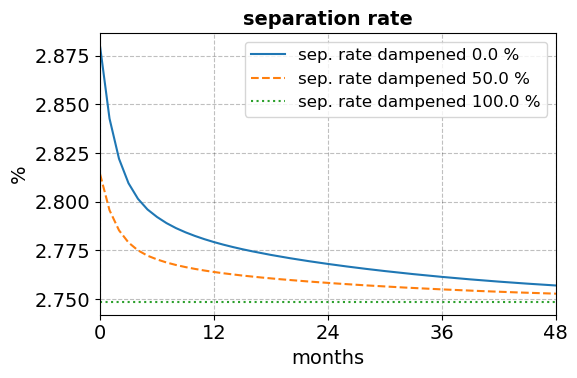

In [6]:
fig,ax = create_fig()

for i_w,(w,ls) in enumerate(zip(ws,lss)):
    ax.plot(deltas[i_w]*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')

save_fig(fig,ax,
         filename='PE_deltas',
         title='separation rate',
         ylabel='%',legend=True)

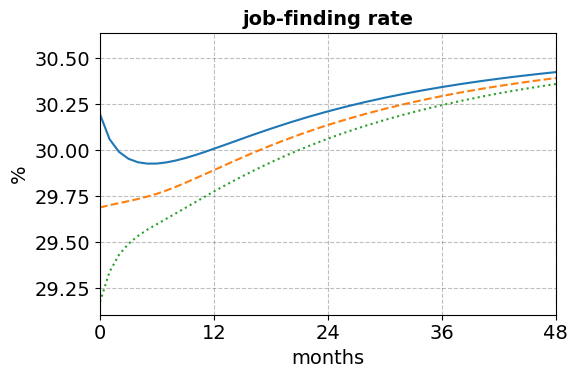

In [7]:
fig,ax = create_fig()

for i_w,(w,ls) in enumerate(zip(ws,lss)):
    ax.plot(lambda_us[i_w]*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
save_fig(fig,ax,
         filename='PE_lambda_us',
         title='job-finding rate',
         ylabel='%',legend=False)

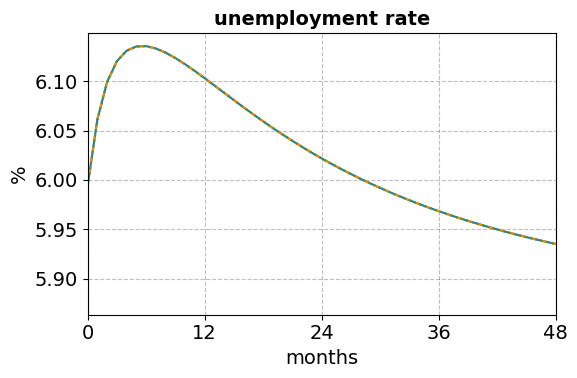

In [8]:
fig,ax = create_fig()

for i_w,(w,ls) in enumerate(zip(ws,lss)):
    ax.plot(model.path.u[0,:]*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
save_fig(fig,ax,
         filename='PE_us',
         title='unemployment rate',
         ylabel='%',legend=False)

In [9]:
models_PE = []
for i_w in range(len(ws)): 
    
    model_ = model.copy()
    
    model_.path.shock_beta[0,:] = model_.ss.shock_beta
    model_.path.w[0,:] = model_.ss.w
    model_.path.RealR_ex_post[0,:] = model_.ss.RealR_ex_post
    model_.path.tau[0,:] = model_.ss.tau
    model_.path.u_bar[0,:] = model_.ss.u_bar
    model_.path.phi_obar[0,:] = model_.ss.phi_obar
    model_.path.transfer[0,:] = model_.ss.transfer
        
    model_.path.delta[0,:] = deltas[i_w]
    model_.path.lambda_u[0,:] = lambda_us[i_w]
            
    model_.solve_hh_path()
    model_.simulate_hh_path()
    
    models_PE.append(model_)
        

In [10]:
model_ = models_PE[0]

In [11]:
assert np.allclose(np.sum(model_.path.D[:,:,1:,:],axis=(1,2,3))-model.path.u[0,:],0.0)

## Alternative consumption paths

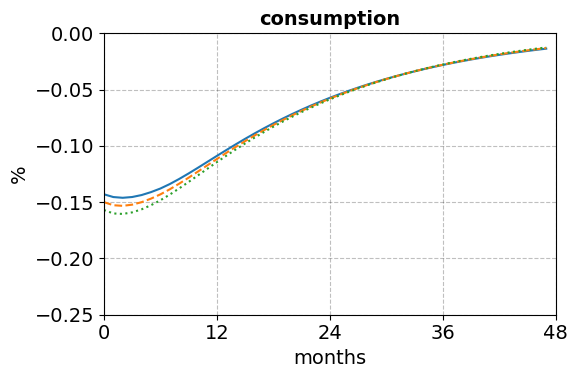

In [12]:
fig,ax = create_fig()

for model_,w,ls in zip(models_PE,ws,lss):
    
    C_hh = np.array([np.sum(model_.path.c[t]*model_.path.D[t]) for t in range(par.T)])   
    ax.plot((C_hh[:48]/ss.C_hh-1)*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')

ax.set_ylim([-0.25,0.0])
save_fig(fig,ax,
         filename='PE_C_hhs',
         title='consumption',
         ylabel='%',legend=False)

## Employed vs. unemployed

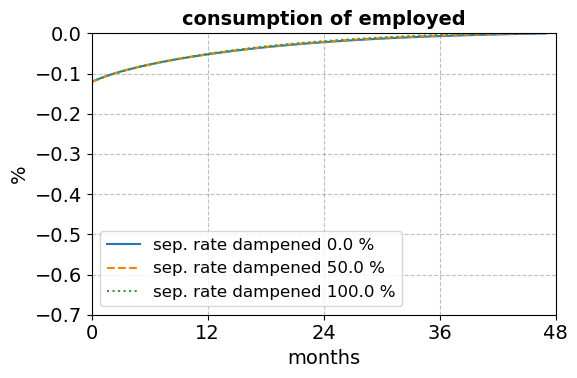

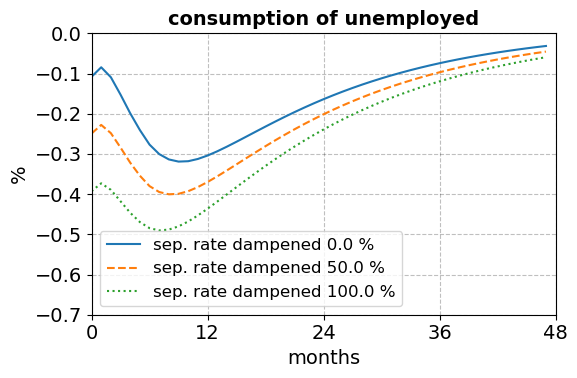

In [13]:
for u in range(2):
    
    fig,ax = create_fig()
    
    if u == 0:
        i = 0
        j = 1
    else:
        i = 1
        j = par.Nz
    
    for model_,w,ls in zip(models_PE,ws,lss):
        C_hh = np.array([np.sum(model_.path.c[t,:,i:j]*model_.path.D[t,:,i:j])/np.sum(model_.path.D[t,:,i:j]) for t in range(par.T)])   
        C_hh_ss = np.sum(model_.ss.c[:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j])
        ax.plot((C_hh[:48]/C_hh_ss-1)*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
    if u == 0:
        group = 'employed'  
        ax.set_ylim([-0.70,0.0])
    else:
        group = 'unemployed'
        ax.set_ylim([-0.70,0.0])
    
    save_fig(fig,ax,
             filename=f'PE_C_hhs_{group}',
             title=f'consumption of {group}',
             ylabel='%',legend=True)
    

## Employed vs. unemployed (only behavioral effect)

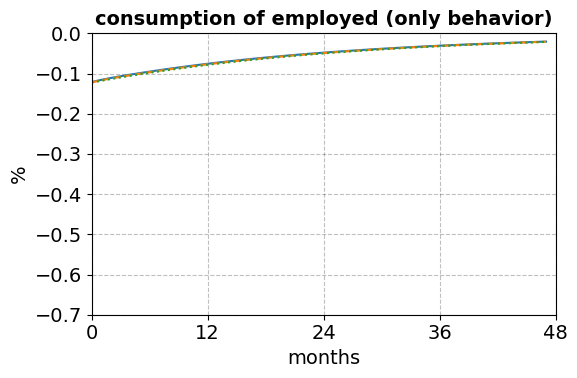

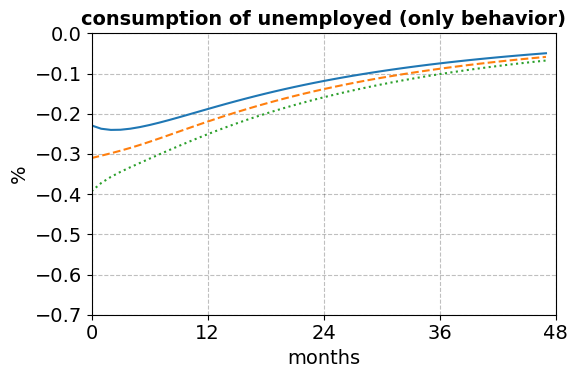

In [14]:
for u in range(2):
    
    fig,ax = create_fig()
    
    if u == 0:
        i = 0
        j = 1
    else:
        i = 1
        j = par.Nz
    
    for model_,w,ls in zip(models_PE,ws,lss):
        C_hh = np.array([np.sum(model_.path.c[t,:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j]) for t in range(par.T)])   
        C_hh_ss =np.sum(model_.ss.c[:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j])
        ax.plot((C_hh[:48]/C_hh_ss-1)*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
    if u == 0:
        group = 'employed'  
        ax.set_ylim([-0.70,0.0])
    else:
        group = 'unemployed'
        ax.set_ylim([-0.70,0.0])
        
    save_fig(fig,ax,
             filename=f'PE_C_hhs_{group}_only_behavior',
             title=f'consumption of {group} (only behavior)',
             ylabel='%',legend=False)


## Alternative Savings paths

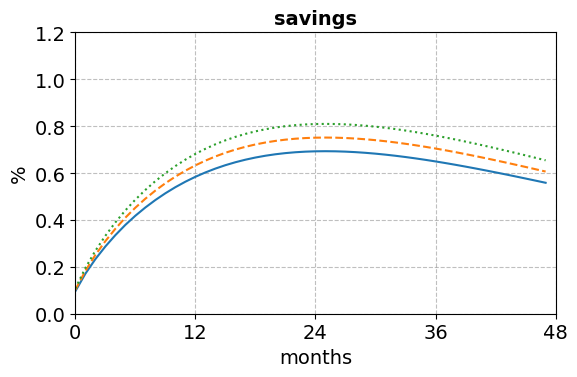

In [15]:
fig,ax = create_fig()
                     
for model_,w,ls in zip(models_PE,ws,lss):
    A_hh = np.array([np.sum(model_.path.a[t]*model_.path.D[t]) for t in range(par.T)])   
    ax.plot((A_hh[:48]/ss.A_hh-1)*100,ls,label=f'sep. rate dampened {w*100:.1f} %')

ax.set_ylim([0,1.2])
save_fig(fig,ax,
         filename='PE_A_hhs',
         title='savings',
         ylabel='%',legend=False)

## Employed vs. unemployed

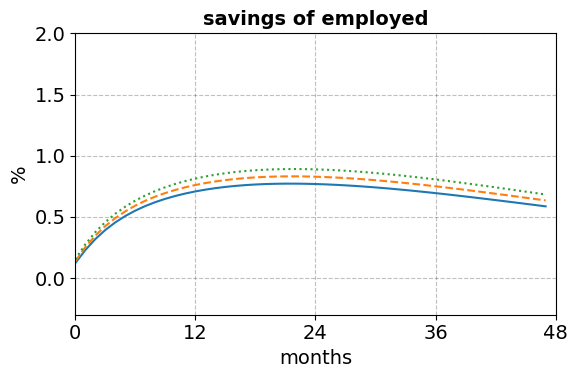

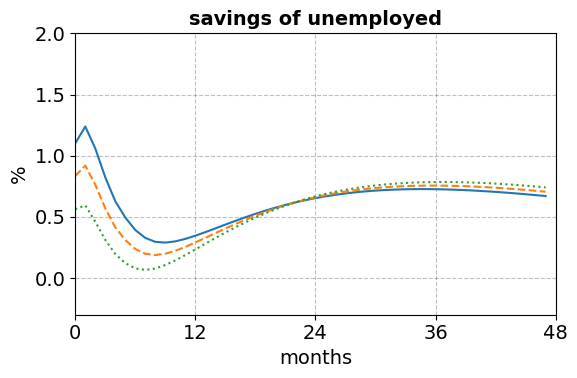

In [16]:
for u in range(2):
    
    fig,ax = create_fig()
    
    if u == 0:
        i = 0
        j = 1
    else:
        i = 1
        j = par.Nz
    
    for model_,w,ls in zip(models_PE,ws,lss):
        C_hh = np.array([np.sum(model_.path.a[t,:,i:j]*model_.path.D[t,:,i:j])/np.sum(model_.path.D[t,:,i:j]) for t in range(par.T)])   
        C_hh_ss = np.sum(model_.ss.a[:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j])
        ax.plot((C_hh[:48]/C_hh_ss-1)*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
    if u == 0:
        group = 'employed'  
        ax.set_ylim([-0.3,2.0])
    else:
        group = 'unemployed'
        ax.set_ylim([-0.3,2.0])
        
    save_fig(fig,ax,
             filename=f'PE_A_hhs_{group}',
             title=f'savings of {group}',
             ylabel='%',legend=False)


## Employed vs. unemployed (only behavioral effect)

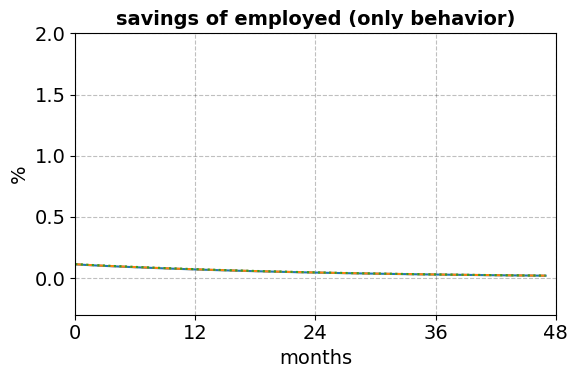

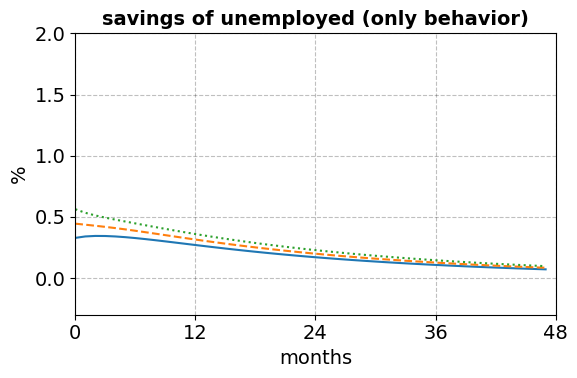

In [17]:
for u in range(2):
    
    fig,ax = create_fig()
    
    if u == 0:
        i = 0
        j = 1
    else:
        i = 1
        j = par.Nz
    
    for model_,w,ls in zip(models_PE,ws,lss):
        C_hh = np.array([np.sum(model_.path.a[t,:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j]) for t in range(par.T)])   
        C_hh_ss = np.sum(model_.ss.a[:,i:j]*model_.ss.D[:,i:j])/np.sum(model_.ss.D[:,i:j])
        ax.plot((C_hh[:48]/C_hh_ss-1)*100,ls=ls,label=f'sep. rate dampened {w*100:.1f} %')
    
    if u == 0:
        group = 'employed'  
        ax.set_ylim([-0.3,2.0])
    else:
        group = 'unemployed'
        ax.set_ylim([-0.3,2.0])
        
    save_fig(fig,ax,
             filename=f'PE_A_hhs_{group}_only_behavior',
             title=f'savings of {group} (only behavior)',
             ylabel='%',legend=False)
